# Imports and Data Loading

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision import transforms
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Check Torch version
print(torch.__version__)

# Downloading and Loading MNIST Dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_set = MNIST(root='./', train=True, download=True, transform=transform)
test_set = MNIST(root='./', train=False, download=True, transform=transform)

# Data Loaders and Training/Validation Split
num_workers = 0
batch_size = 128
valid_size = 0.2

# Creating data indices for training and validation splits
num_train = len(train_set)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_index, valid_index = indices[split:], indices[:split]

# Creating PT data samplers and loaders
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)

train_loader = DataLoader(train_set, batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = DataLoader(train_set, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=num_workers)


2.1.0+cu118


# Shared Utility Functions

In [2]:
# Function Gets the number of true positives by comparing the predictions and labels
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
# Function to denormalize the image

def denormalize(tensor):
    return tensor * 0.5 + 0.5

# Function get get the accuracy of the AE models
def get_accuracy(y_true, y_prob):
    assert y_true.size() == y_prob.size()
    y_prob = y_prob > 0.5
    return (y_true == y_prob).sum().item() / (y_true.size(dim=0)*y_true.size(dim=1))

# Models and Training


## Exercise 1 MLP Model

In [3]:
class MLP(nn.Module):
    # Inilize variables
    def __init__(self):
        super(MLP, self).__init__()
        self.Input = nn.Linear(in_features=784,out_features=512)
        self.Dropout1 = nn.Dropout(0.2)
        self.Hidden = nn.Linear(in_features=512,out_features=512)
        self.Dropout2 = nn.Dropout(0.2)
        self.Predictions = nn.Linear(in_features=512,out_features=10)
    # forward is used to describe the behavior of the model during a feed forward pass
    def forward(self, input_tensor):
        #Flatten the w and h of the image (2D --> 1D)
        x = torch.flatten(input_tensor,start_dim=1)
        x = self.Input(x)
        #Apply non linear activation function relu
        x = F.relu(x)
        x = self.Dropout1(x)
        x = self.Hidden(x)
        x = F.relu(x)
        x = self.Dropout2(x)
        x = self.Predictions(x)
        #Apply Softmax to the output of the model then return the result
        x = F.log_softmax(x, dim=1)
        return x
    # __repr__ returns the models architecture when called
    def __repr__(self):
        return super().__repr__()

### Training MLP Model Function

In [4]:
# Criterion and Optimizer
model = MLP()
optimizer = optim.RMSprop(model.parameters(),lr=0.01)
n_epochs = 20

Epoch: 1 	Training Loss: 21.560231 	Validation Loss: 0.422463 	Accuracy: 0.697917 	Validation Accuracy: 0.872917
Epoch: 2 	Training Loss: 0.816055 	Validation Loss: 0.473179 	Accuracy: 0.761750 	Validation Accuracy: 0.852500
Epoch: 3 	Training Loss: 0.682272 	Validation Loss: 0.452414 	Accuracy: 0.802625 	Validation Accuracy: 0.876417
Epoch: 4 	Training Loss: 0.779984 	Validation Loss: 0.570660 	Accuracy: 0.794729 	Validation Accuracy: 0.853417
Epoch: 5 	Training Loss: 0.559610 	Validation Loss: 0.656206 	Accuracy: 0.845229 	Validation Accuracy: 0.781833
Epoch: 6 	Training Loss: 0.603063 	Validation Loss: 0.337389 	Accuracy: 0.835812 	Validation Accuracy: 0.902083
Epoch: 7 	Training Loss: 0.542955 	Validation Loss: 0.325817 	Accuracy: 0.851417 	Validation Accuracy: 0.908500
Epoch: 8 	Training Loss: 0.515792 	Validation Loss: 0.526141 	Accuracy: 0.860479 	Validation Accuracy: 0.834750
Epoch: 9 	Training Loss: 0.512770 	Validation Loss: 0.299647 	Accuracy: 0.863104 	Validation Accuracy: 

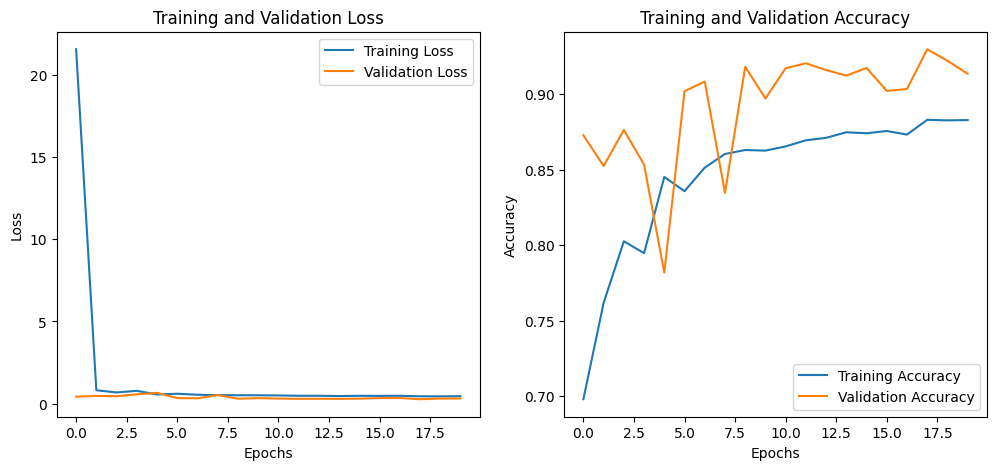

In [5]:
import matplotlib.pyplot as plt

n_epochs = 20  # Adjust as needed
train_losses = []
val_losses = []
accuracies = []
val_accuracies = []

for epoch in range(n_epochs):
    train_loss = 0.0
    val_loss = 0.0
    train_correct = 0
    val_correct = 0

    # Training phase
    model.train()
    for batch in train_loader:
        images, labels = batch
        optimizer.zero_grad()
        preds = model(images)
        loss = F.cross_entropy(preds, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        train_correct += get_num_correct(preds, labels)

    # Validation phase
    model.eval()
    for batch in valid_loader:
        images, labels = batch
        preds = model(images)
        loss = F.cross_entropy(preds, labels)

        val_loss += loss.item() * images.size(0)
        val_correct += get_num_correct(preds, labels)

    # Calculate average loss and accuracy
    train_loss = train_loss / len(train_loader.sampler)
    val_loss = val_loss / len(valid_loader.sampler)
    accuracy = train_correct / len(train_loader.sampler)
    val_accuracy = val_correct / len(valid_loader.sampler)

    # Record the metrics for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    accuracies.append(accuracy)
    val_accuracies.append(val_accuracy)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tAccuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch+1, 
        train_loss,
        val_loss,
        accuracy,
        val_accuracy
        ))

# Plotting
plt.figure(figsize=(12, 5))

# Plot training and validation losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


### Confusion Matrix function

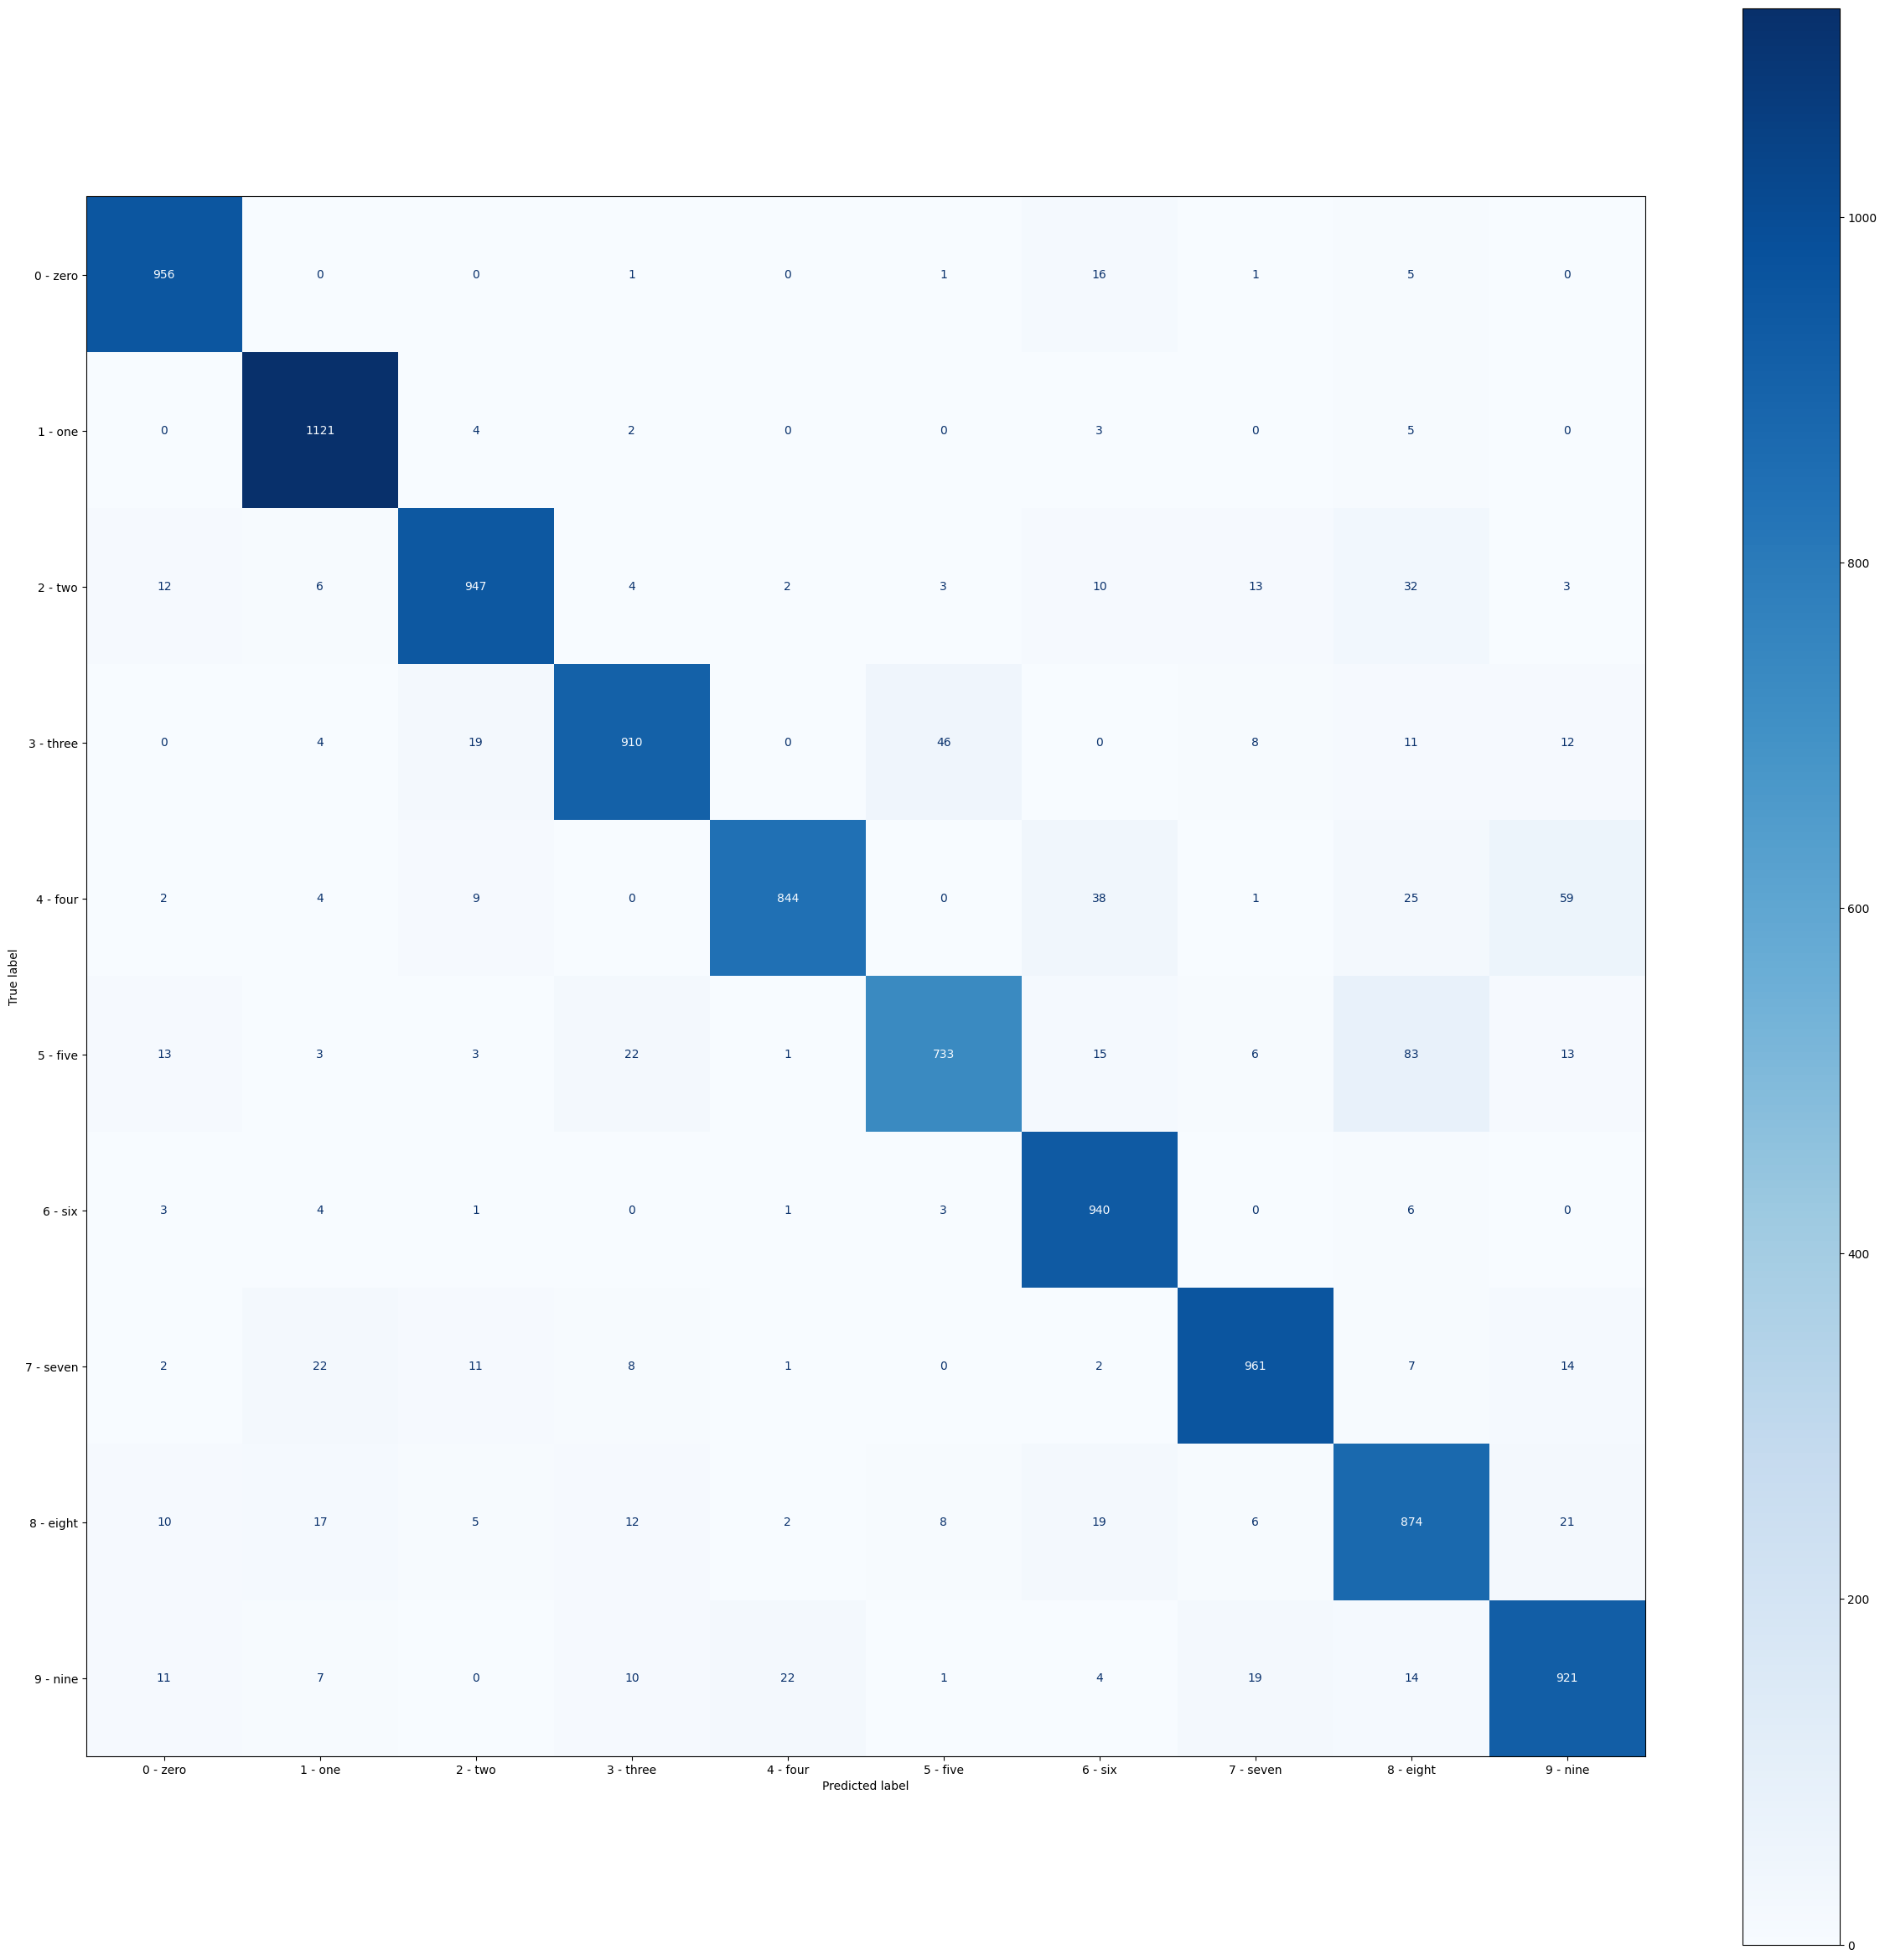

Test Loss: 0.306384

Test Accuracy of     0: 97% (956/980)
Test Accuracy of     1: 98% (1121/1135)
Test Accuracy of     2: 91% (947/1032)
Test Accuracy of     3: 90% (910/1010)
Test Accuracy of     4: 85% (844/982)
Test Accuracy of     5: 82% (733/892)
Test Accuracy of     6: 98% (940/958)
Test Accuracy of     7: 93% (961/1028)
Test Accuracy of     8: 89% (874/974)
Test Accuracy of     9: 91% (921/1009)


In [6]:
y_pred = []
y_tr = []
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval()
for batch in test_loader:
    images, labels = batch
    preds = model(images)
    y_pred.extend(np.argmax(preds.detach().numpy(), axis=1))
    y_tr.extend(labels.detach().numpy())
    loss = F.cross_entropy(preds, labels)
    test_loss += loss.item()* images.size(0)
    _, pred = torch.max(preds, 1)
    correct = np.squeeze(pred.eq(labels.data.view_as(pred)))
    for i in range(len(labels)):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
cm = confusion_matrix(y_true=y_tr, y_pred=y_pred)
lbls = test_set.classes
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lbls)
fig, ax = plt.subplots(figsize=(30,30))
cmp.plot(cmap=plt.cm.Blues,ax=ax)
plt.show()
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))

## Exercise 2 CNN Model

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc2(x), dim=1)
        return x


In [8]:
# Criterion and Optimizer
model = CNN()
optimizer = optim.SGD(model.parameters(),lr=0.001)
n_epochs = 20

### Training the model

Epoch: 1 	Training Loss: 2.285745 	Validation Loss: 2.266929 	Accuracy: 0.161562 	Validation Accuracy: 0.479667
Epoch: 2 	Training Loss: 2.248019 	Validation Loss: 2.222653 	Accuracy: 0.292312 	Validation Accuracy: 0.580083
Epoch: 3 	Training Loss: 2.191621 	Validation Loss: 2.151452 	Accuracy: 0.409729 	Validation Accuracy: 0.631083
Epoch: 4 	Training Loss: 2.101618 	Validation Loss: 2.026832 	Accuracy: 0.486396 	Validation Accuracy: 0.659417
Epoch: 5 	Training Loss: 1.942520 	Validation Loss: 1.811348 	Accuracy: 0.533667 	Validation Accuracy: 0.688417
Epoch: 6 	Training Loss: 1.698237 	Validation Loss: 1.504228 	Accuracy: 0.578688 	Validation Accuracy: 0.729167
Epoch: 7 	Training Loss: 1.418434 	Validation Loss: 1.184889 	Accuracy: 0.628062 	Validation Accuracy: 0.768417
Epoch: 8 	Training Loss: 1.161785 	Validation Loss: 0.929241 	Accuracy: 0.681854 	Validation Accuracy: 0.811750
Epoch: 9 	Training Loss: 0.969713 	Validation Loss: 0.754262 	Accuracy: 0.725646 	Validation Accuracy: 0

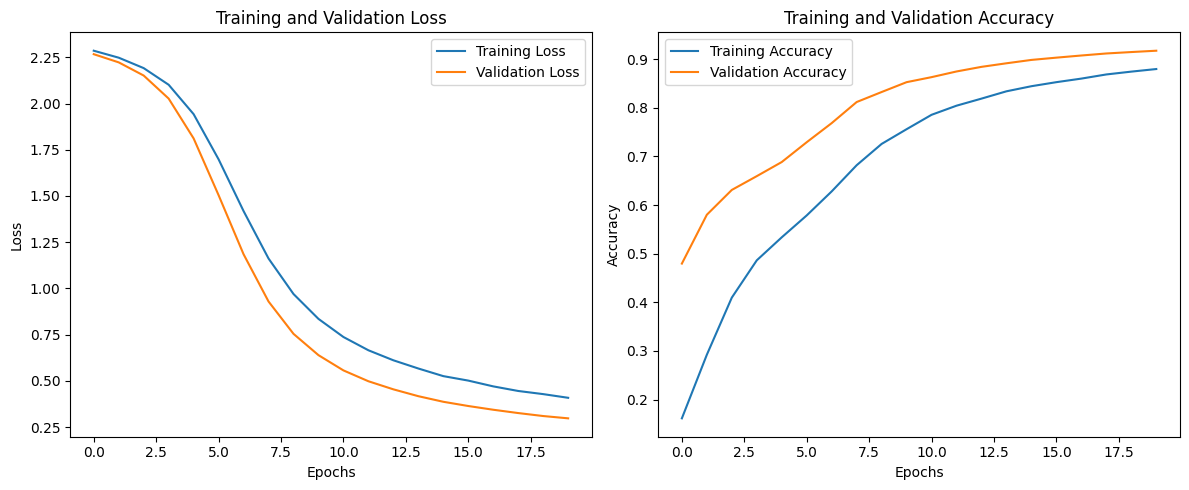

In [9]:
import matplotlib.pyplot as plt

n_epochs = 20  # Adjust as needed
train_losses = []
val_losses = []
accuracies = []
val_accuracies = []

for epoch in range(n_epochs):
    train_loss = 0.0
    val_loss = 0.0
    train_correct = 0
    val_correct = 0

    # Training phase
    model.train()
    for batch in train_loader:
        images, labels = batch
        optimizer.zero_grad()
        preds = model(images)
        loss = F.cross_entropy(preds, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        train_correct += get_num_correct(preds, labels)

    # Validation phase
    model.eval()
    for batch in valid_loader:
        images, labels = batch
        preds = model(images)
        loss = F.cross_entropy(preds, labels)

        val_loss += loss.item() * images.size(0)
        val_correct += get_num_correct(preds, labels)

    # Calculate average losses and accuracies
    train_loss = train_loss / len(train_loader.sampler)
    val_loss = val_loss / len(valid_loader.sampler)
    accuracy = train_correct / len(train_loader.sampler)
    val_accuracy = val_correct / len(valid_loader.sampler)

    # Record the metrics for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    accuracies.append(accuracy)
    val_accuracies.append(val_accuracy)

    # Print epoch metrics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tAccuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch+1, 
        train_loss,
        val_loss,
        accuracy,
        val_accuracy
    ))

# Plotting the training and validation losses and accuracies
plt.figure(figsize=(12, 5))

# Plot training and validation losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


### Confusion Matrix

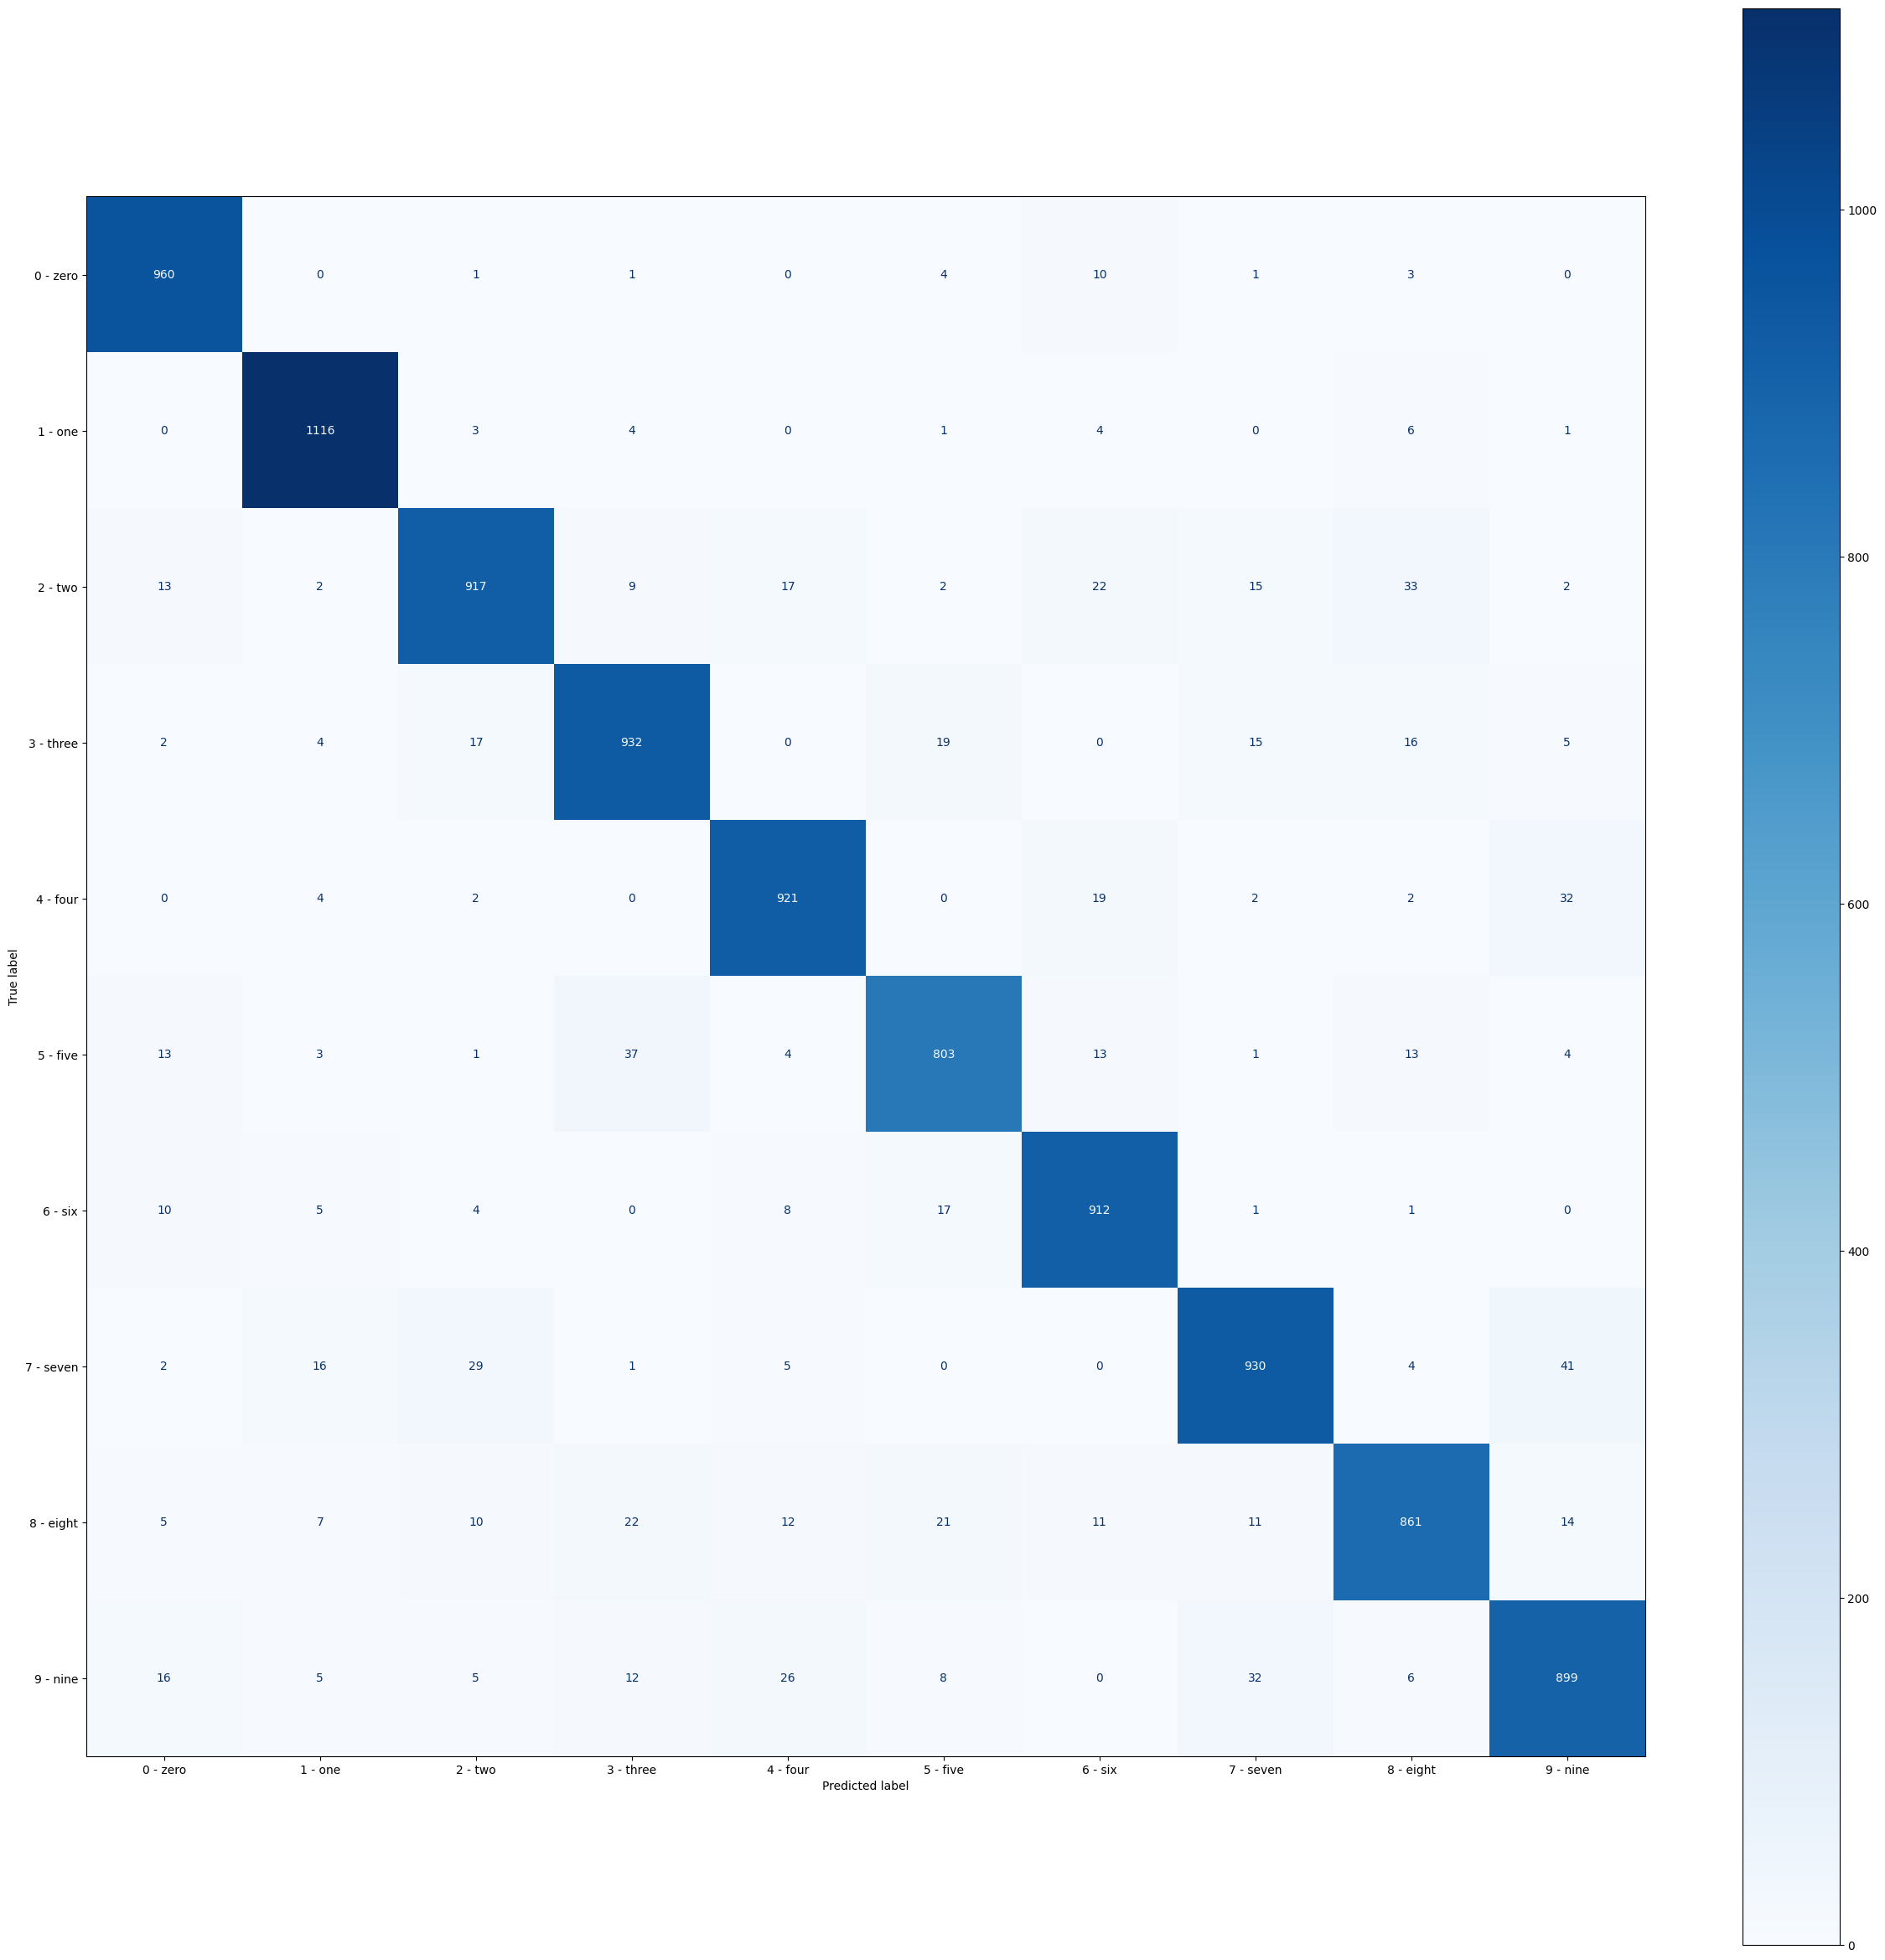

Test Loss: 0.278458

Test Accuracy of     0: 97% (960/980)
Test Accuracy of     1: 98% (1116/1135)
Test Accuracy of     2: 88% (917/1032)
Test Accuracy of     3: 92% (932/1010)
Test Accuracy of     4: 93% (921/982)
Test Accuracy of     5: 90% (803/892)
Test Accuracy of     6: 95% (912/958)
Test Accuracy of     7: 90% (930/1028)
Test Accuracy of     8: 88% (861/974)
Test Accuracy of     9: 89% (899/1009)


In [10]:
y_pred = []
y_tr = []
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval()
for batch in test_loader:
    images, labels = batch
    preds = model(images)
    y_pred.extend(np.argmax(preds.detach().numpy(), axis=1))
    y_tr.extend(labels.detach().numpy())
    loss = F.cross_entropy(preds, labels)
    test_loss += loss.item()* images.size(0)
    _, pred = torch.max(preds, 1)
    correct = np.squeeze(pred.eq(labels.data.view_as(pred)))
    for i in range(len(labels)):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
cm = confusion_matrix(y_true=y_tr, y_pred=y_pred)
lbls = test_set.classes
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lbls)
fig, ax = plt.subplots(figsize=(30,30))
cmp.plot(cmap=plt.cm.Blues,ax=ax)
plt.show()
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))

## EXERCISE 3 Autoencoder

In [11]:
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [12]:
# Initialize the model, criterion, and optimizer
encoding_dim = 32
autoencoder = Autoencoder(encoding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

### Training the autoencoder

Epoch: 1/40 	Training Loss: 0.789421 	Validation Loss: 0.186448
Epoch: 2/40 	Training Loss: 0.740268 	Validation Loss: 0.184299
Epoch: 3/40 	Training Loss: 0.735285 	Validation Loss: 0.183344
Epoch: 4/40 	Training Loss: 0.731806 	Validation Loss: 0.182583
Epoch: 5/40 	Training Loss: 0.729090 	Validation Loss: 0.181880
Epoch: 6/40 	Training Loss: 0.726496 	Validation Loss: 0.181408
Epoch: 7/40 	Training Loss: 0.725033 	Validation Loss: 0.181040
Epoch: 8/40 	Training Loss: 0.723065 	Validation Loss: 0.179847
Epoch: 9/40 	Training Loss: 0.718022 	Validation Loss: 0.179238
Epoch: 10/40 	Training Loss: 0.716091 	Validation Loss: 0.178470
Epoch: 11/40 	Training Loss: 0.712504 	Validation Loss: 0.177716
Epoch: 12/40 	Training Loss: 0.710020 	Validation Loss: 0.177283
Epoch: 13/40 	Training Loss: 0.708685 	Validation Loss: 0.176960
Epoch: 14/40 	Training Loss: 0.707244 	Validation Loss: 0.176668
Epoch: 15/40 	Training Loss: 0.706194 	Validation Loss: 0.176381
Epoch: 16/40 	Training Loss: 0.705

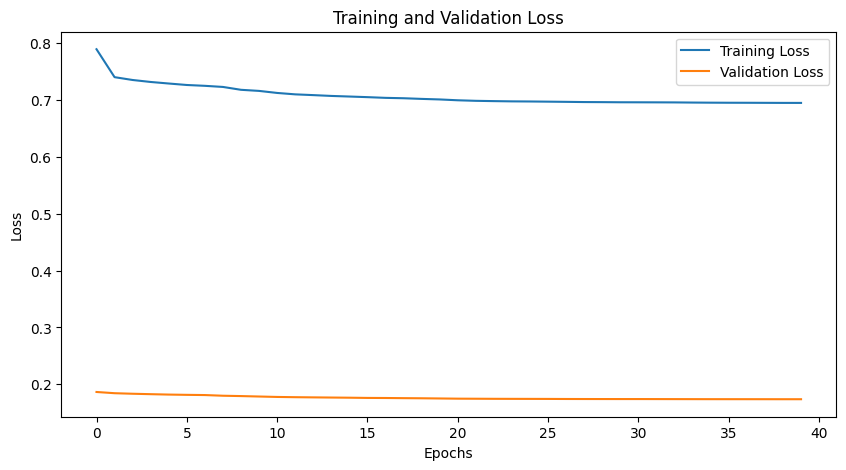

In [13]:

num_epochs = 40
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0

    # Training phase
    autoencoder.train()
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), -1)
        optimizer.zero_grad()
        outputs = autoencoder(img)
        loss = criterion(outputs, img)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * img.size(0)

    # Validation phase
    autoencoder.eval()
    for data in valid_loader:
        img, _ = data
        img = img.view(img.size(0), -1)
        outputs = autoencoder(img)
        loss = criterion(outputs, img)

        val_loss += loss.item() * img.size(0)

    # Calculate average losses
    train_loss = train_loss / len(train_loader.dataset)
    val_loss = val_loss / len(valid_loader.dataset)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch: {epoch+1}/{num_epochs} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {val_loss:.6f}')


### Testing the autoencoder

In [14]:
with torch.no_grad():
    for data in test_loader:
        img, _ = data
        img = img.view(img.size(0), -1)
        encoded_imgs = autoencoder.encoder(img)
        decoded_imgs = autoencoder.decoder(encoded_imgs)

### Convert the results to NumPy arrays

In [15]:
encoded_imgs = encoded_imgs.numpy()
decoded_imgs = decoded_imgs.numpy()

### Display Original and Constructed images

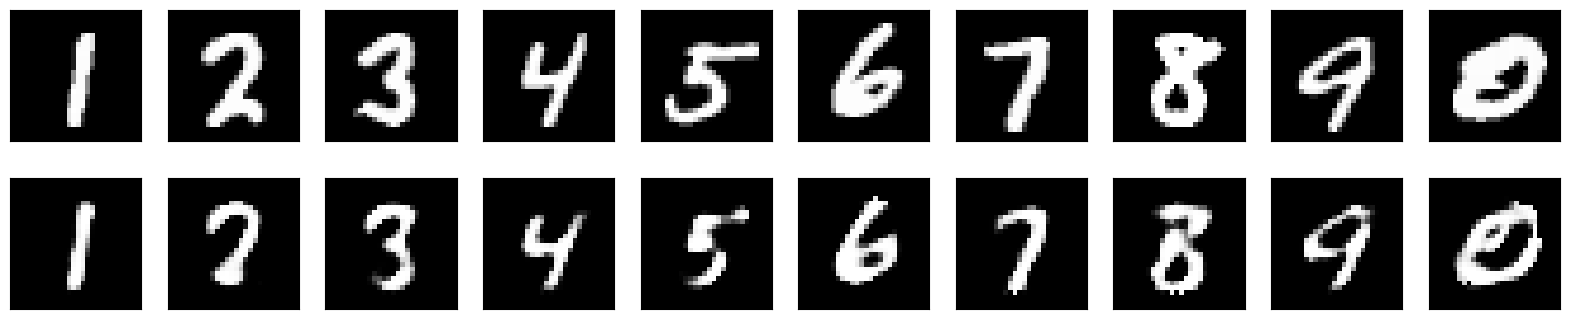

In [16]:
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))

for i in range(n):
    # Original Images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(img[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed Images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## EXERCISE 4 Convolutional Autoencoder

In [17]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=1, padding=1),  # output: 16 x 28 x 28
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 16 x 14 x 14
            nn.Conv2d(16, 32, 3, stride=1, padding=1),  # output: 32 x 14 x 14
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 32 x 7 x 7
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(32, 16, 3, stride=1, padding=1),  # output: 16 x 7 x 7
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),  # output: 16 x 14 x 14
            nn.Conv2d(16, 8, 3, stride=1, padding=1),  # output: 8 x 14 x 14
            nn.ReLU(),
            nn.Upsample(scale_factor=2),  # output: 8 x 28 x 28
            nn.Conv2d(8, 1, 3, stride=1, padding=1),  # output: 1 x 28 x 28
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [18]:
# criterion, model, optimizer
model = ConvAutoencoder()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
num_epochs = 10

### Training the Convotional Autoencoder

Epoch: 1/10 	Training Loss: 0.740304 	Validation Loss: 0.170245
Epoch: 2/10 	Training Loss: 0.677845 	Validation Loss: 0.169065
Epoch: 3/10 	Training Loss: 0.674808 	Validation Loss: 0.168384
Epoch: 4/10 	Training Loss: 0.673589 	Validation Loss: 0.168164
Epoch: 5/10 	Training Loss: 0.672685 	Validation Loss: 0.168014
Epoch: 6/10 	Training Loss: 0.672135 	Validation Loss: 0.167858
Epoch: 7/10 	Training Loss: 0.671699 	Validation Loss: 0.167763
Epoch: 8/10 	Training Loss: 0.671347 	Validation Loss: 0.167734
Epoch: 9/10 	Training Loss: 0.671163 	Validation Loss: 0.167634
Epoch: 10/10 	Training Loss: 0.670848 	Validation Loss: 0.167642


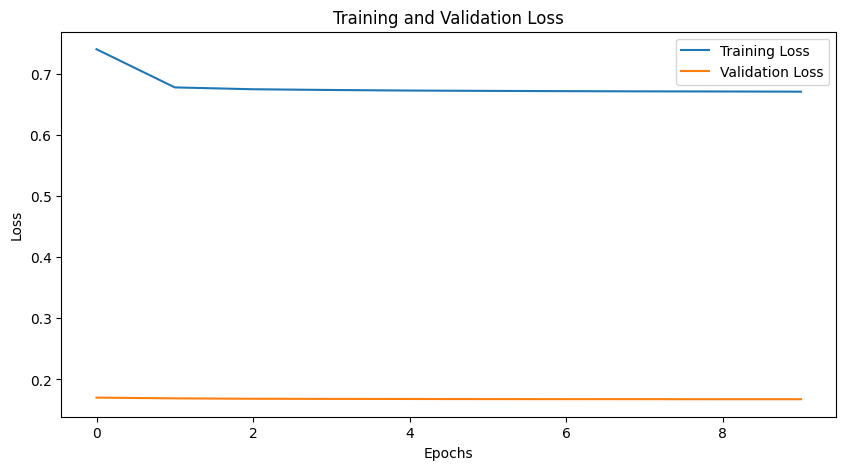

In [19]:
import matplotlib.pyplot as plt

num_epochs = 10  # Adjust as needed
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0

    # Training phase
    model.train()
    for data in train_loader:
        img, _ = data
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * img.size(0)

    # Validation phase
    model.eval()
    for data in valid_loader:
        img, _ = data
        output = model(img)
        loss = criterion(output, img)
        val_loss += loss.item() * img.size(0)

    # Calculate average losses
    train_loss = train_loss / len(train_loader.dataset)
    val_loss = val_loss / len(valid_loader.dataset)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch: {epoch+1}/{num_epochs} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {val_loss:.6f}')



### Testing the autoencoder

In [20]:

# Set the model to evaluation mode
model.eval()

# Get a batch of test images
test_images, _ = next(iter(test_loader))

# Generate reconstructed images
with torch.no_grad():
    reconstructed_images = model(test_images)

# Apply denormalization
test_images = denormalize(test_images)
reconstructed_images = denormalize(reconstructed_images)


### Ploting the original and reconstructed imagese

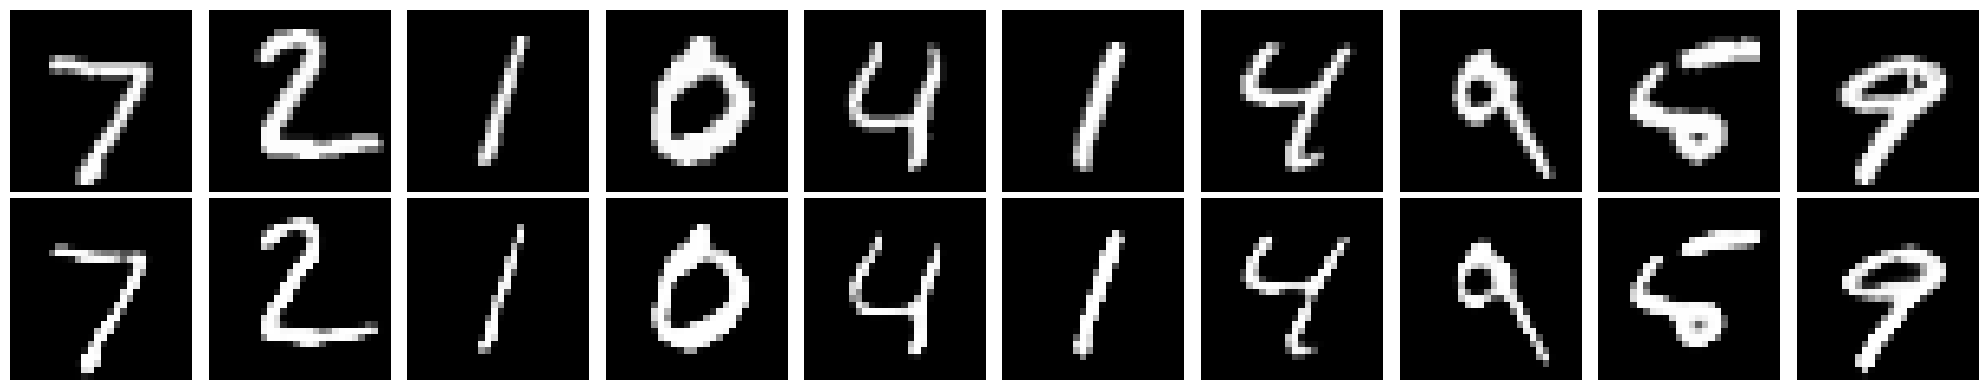

In [21]:

# Plot the original and reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(20, 4))

# Plot original images
for i in range(10):
    axes[0, i].imshow(test_images[i].squeeze(), cmap='gray')
    axes[0, i].axis('off')

# Plot reconstructed images
for i in range(10):
    axes[1, i].imshow(reconstructed_images[i].squeeze(), cmap='gray')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


# Exercise 5 Denoising AE for MNIST

Training the Autoencoder with noise

In [47]:
noise_factor = 0.1
device = torch.device("cpu")
for images, labels in train_loader:
    # Add noise to the images
    noisy_images = images + noise_factor * torch.randn(*images.shape)
    noisy_images = np.clip(noisy_images, 0., 1.)

    # Move the images and labels to the GPU if available
    noisy_images = noisy_images.to(device)

    # Reshape the images into a 4D tensor
    noisy_images = noisy_images.view(noisy_images.size(0), 1, 28, 28).to(device)

    # Forward pass
    outputs = autoencoder(noisy_images)
    outputs = outputs.view(images.size())

    # Compute the loss
    loss = criterion(outputs, images)

    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Plot the Training Metrics

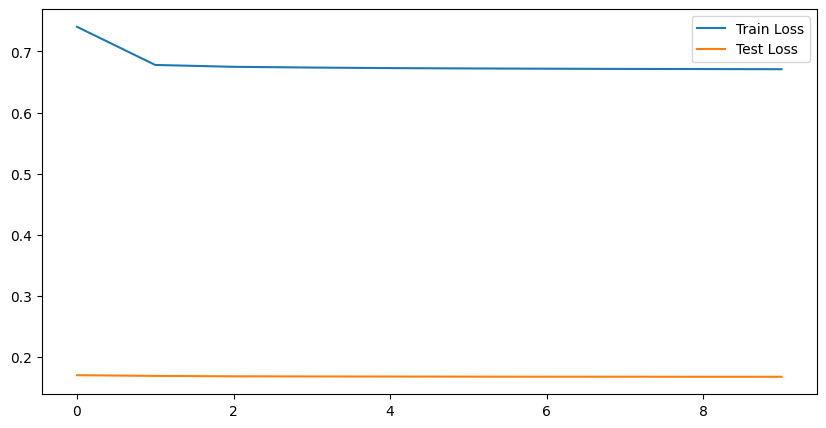

In [48]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Test Loss')
plt.legend()
plt.show()

Comparing Original, Noisy, and Reconstructed Images

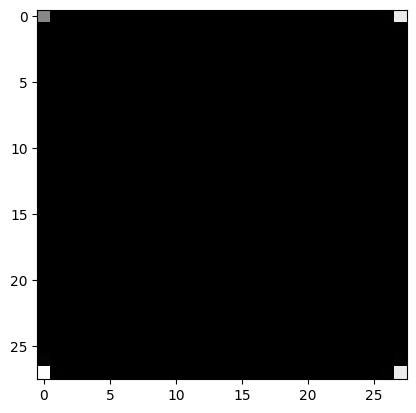

In [54]:
# Get a batch of test images
test_images, _ = next(iter(test_loader))

# Add noise to the test images
noisy_images = test_images + noise_factor * torch.randn(*test_images.shape)
noisy_images = torch.clamp(noisy_images, 0., 1.)

# Move the images to the GPU if available
noisy_images = noisy_images.to(device)

# Reshape the images into a 4D tensor
noisy_images = noisy_images.view(noisy_images.size(0), 1, 28, 28).to(device)

# Reconstruct the images using the autoencoder
reconstructed_images = autoencoder(noisy_images)
reconstructed_images

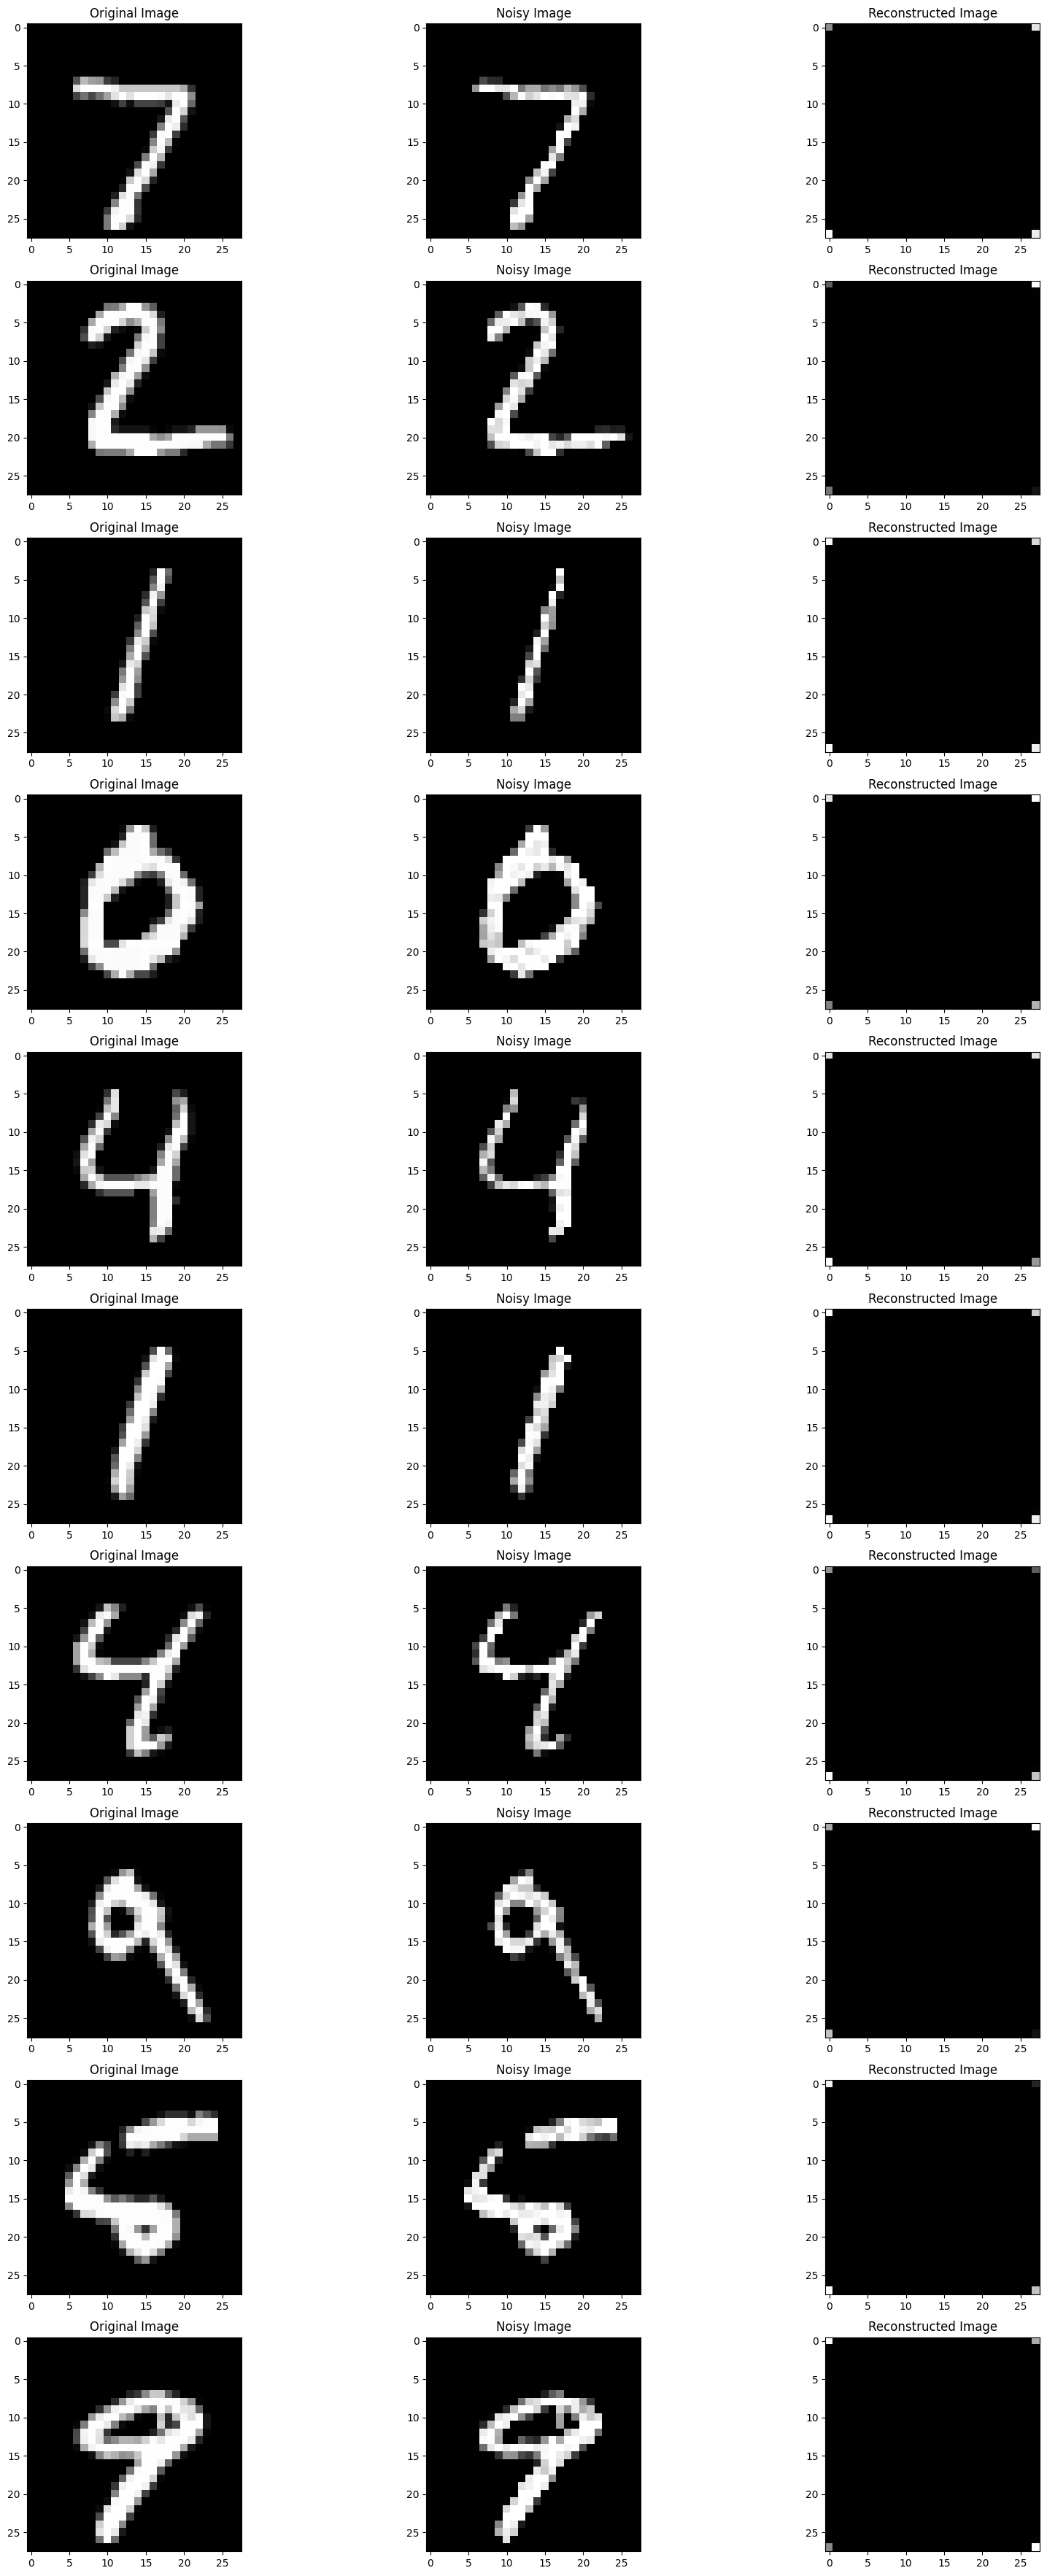

In [52]:

# Plot the original, noisy, and reconstructed images
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(20, 45))
for i in range(10):
    # Original images
    axes[i, 0].imshow(test_images[i].reshape(28, 28), cmap='gray')
    axes[i, 0].set_title('Original Image')

    # Noisy images
    axes[i, 1].imshow(noisy_images[i].reshape(28, 28), cmap='gray')
    axes[i, 1].set_title('Noisy Image')

    # Reconstructed images
    axes[i, 2].imshow(reconstructed_images[i].detach().reshape(28, 28), cmap='gray')
    axes[i, 2].set_title('Reconstructed Image')